https://github.com/huggingface/peft/blob/main/examples/fp4_finetuning/finetune_fp4_opt_bnb_peft.py

In [1]:
from torch import optim
import lightning as pl
from matplotlib import pyplot as plt

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import warnings
from peft import LoraConfig, get_peft_model, IA3Config

In [3]:
plt.style.use('ggplot')
torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [4]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model_name = "microsoft/phi-2"

# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     # max_memory=max_memory,
#     quantization_config=BitsAndBytesConfig(
#         load_in_4bit=True,
#         llm_int8_threshold=6.0,
#         llm_int8_has_fp16_weight=False,
#         bnb_4bit_compute_dtype=torch.float16,
#         bnb_4bit_use_double_quant=True,
#         bnb_4bit_quant_type="nf4",
#     ),
#     torch_dtype=torch.float16,
#     trust_remote_code=True,
# )






In [5]:
# model_name = "TheBloke/phi-2-GPTQ"
model_name = "microsoft/phi-2"

def load_model():

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # quantization_config=BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     llm_int8_threshold=6.0,
        #     llm_int8_has_fp16_weight=False,
        #     bnb_4bit_compute_dtype=torch.float16,
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_quant_type="nf4",
        # ),
        torch_dtype=torch.float16,
        trust_remote_code=True,
    )


    # config = AutoConfig.from_pretrained(model_name, trust_remote_code=True,)
    # config.quantization_config['use_exllama'] = False
    # config.quantization_config['disable_exllama'] = True
    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name,
    #     torch_dtype=torch.bfloat16,
    #     trust_remote_code=True,
    #     config=config,
    # )
    return model


In [6]:
base_model = load_model()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def reset_model(base_model):
    # peft_config = LoraConfig(
    #     # task_type=TaskType.TOKEN_CLS, 
    #     target_modules=[ "fc2",  "Wqkv",],
    #     inference_mode=False, r=4, lora_alpha=4, 
    #     # lora_dropout=0.1, 
    #     # bias="all"
    # )
    peft_config = IA3Config(
        target_modules=[ "fc2",  "Wqkv",], 
            feedforward_modules=["fc2"],
            inference_mode=False,
    )
    model = get_peft_model(base_model, peft_config)
    model.config.use_cache = False
    return model

model = reset_model(base_model)

In [8]:
import json
MAX_LEN = 2000
samples = json.load(open("../samples.json"))


## Helpers

In [9]:
# modified from https://github.dev/huggingface/evaluate/blob/8dfe05784099fb9af55b8e77793205a3b7c86465/measurements/perplexity/perplexity.py#L154

# from evaluate.measurements.perplexity import Perplexity
import evaluate
from evaluate import logging
from torch.nn import CrossEntropyLoss

# @evaluate.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
def perplexity_compute(
    data, model, tokenizer, batch_size: int = 16, add_start_token: bool = True, device=None, max_length=None
):

    if device is not None:
        assert device in ["gpu", "cpu", "cuda"], "device should be either gpu or cpu."
        if device == "gpu":
            device = "cuda"
    else:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # model = AutoModelForCausalLM.from_pretrained(model_id)
    model = model.to(device)

    # tokenizer = AutoTokenizer.from_pretrained(model_id)

    # # if batch_size > 1 (which generally leads to padding being required), and
    # # if there is not an already assigned pad_token, assign an existing
    # # special token to also be the padding token
    # if tokenizer.pad_token is None and batch_size > 1:
    #     existing_special_tokens = list(tokenizer.special_tokens_map_extended.values())
    #     # check that the model already has at least one special token defined
    #     assert (
    #         len(existing_special_tokens) > 0
    #     ), "If batch_size > 1, model must have at least one special token to use for padding. Please use a different model or set batch_size=1."
    #     # assign one of the special tokens to also be the pad token
    #     tokenizer.add_special_tokens({"pad_token": existing_special_tokens[0]})

    # if add_start_token and max_length:
    #     # leave room for <BOS> token to be added:
    #     assert (
    #         tokenizer.bos_token is not None
    #     ), "Input model must already have a BOS token if using add_start_token=True. Please use a different model, or set add_start_token=False"
    #     max_tokenized_len = max_length - 1
    # else:
    max_tokenized_len = max_length

    encodings = tokenizer(
        data,
        add_special_tokens=False,
        padding=True,
        truncation=True if max_tokenized_len else False,
        max_length=max_tokenized_len,
        return_tensors="pt",
        return_attention_mask=True,
    ).to(device)

    encoded_texts = encodings["input_ids"]
    attn_masks = encodings["attention_mask"]

    # check that each input is long enough:
    if add_start_token:
        assert torch.all(torch.ge(attn_masks.sum(1), 1)), "Each input text must be at least one token long."
    else:
        assert torch.all(
            torch.ge(attn_masks.sum(1), 2)
        ), "When add_start_token=False, each input text must be at least two tokens long. Run with add_start_token=True if inputting strings of only one token, and remove all empty input strings."

    ppls = []
    loss_fct = CrossEntropyLoss(reduction="none")

    for start_index in logging.tqdm(range(0, len(encoded_texts), batch_size)):
        end_index = min(start_index + batch_size, len(encoded_texts))
        encoded_batch = encoded_texts[start_index:end_index]
        attn_mask = attn_masks[start_index:end_index]

        # if add_start_token:
        #     bos_tokens_tensor = torch.tensor([[tokenizer.bos_token_id]] * encoded_batch.size(dim=0)).to(device)
        #     encoded_batch = torch.cat([bos_tokens_tensor, encoded_batch], dim=1)
        #     attn_mask = torch.cat(
        #         [torch.ones(bos_tokens_tensor.size(), dtype=torch.int64).to(device), attn_mask], dim=1
        #     )

        labels = encoded_batch

        with torch.no_grad():
            out_logits = model(encoded_batch, attention_mask=attn_mask).logits
            # print(out_logits.shape)

        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_attention_mask_batch = attn_mask[..., 1:].contiguous()

        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
            / shift_attention_mask_batch.sum(1)
        )
        # perplexity_batch = torch.exp(
        #     (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch)
        #     / shift_attention_mask_batch.sum(1)
        # )
        # print(perplexity_batch.shape)

        ppls += perplexity_batch.tolist()

    return {"perplexities": ppls, "mean_perplexity": torch.tensor(ppls).mean()}

In [10]:
# perplexity_compute(
#     second_half, model, tokenizer
# )

## Training

In [11]:
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

## Lightning helpers

In [12]:




# def str2xya(s, tokenizer):
#     max_len = min(MAX_LEN, len(s))
#     input_ids = tokenizer(s, return_tensors="pt")["input_ids"][0]

#     pad = tokenizer.bos_token_id
#     data = []
#     for i in range(1, len(input_ids)):
#         x = input_ids[:i][-max_len:]
#         padding = max_len - len(x)
#         x = torch.tensor([pad]*padding + x.tolist())

#         labels = input_ids[i:i+1]
#         attention_mask = (x==pad)*1
#         data.append(dict(input_ids=x, labels=labels, attention_mask=attention_mask, return_loss=True))
        
#     return data



In [13]:
def eval(model, tokenizer, second_half):
    model.eval();
    with torch.no_grad():
        with model.disable_adapter():
            results = perplexity_compute(data=second_half, model=model, tokenizer=tokenizer, device='cuda')
        results2 = perplexity_compute(data=second_half, model=model, tokenizer=tokenizer, device='cuda')
    return dict(before=results['mean_perplexity'].item(), after=results2['mean_perplexity'].item())


# Train

In [14]:
from datasets import Dataset


def compute_metrics(eval_prediction):
    return {}

Trainer docs

- https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer

In [15]:
def learn_sample(sample):
    # device = 'cuda'
    # lr = 4e-3
    # epochs = 3
    # accum_steps = 1
    batch_size = 6
    verbose = True

    s = sample['text']
    first_half = s[:len(s)//2]
    second_half = s[len(s)//2:]
    ds_train = Dataset.from_dict(tokenizer([first_half]))
    ds_val = Dataset.from_dict(tokenizer([second_half]))

    os.environ['CUDA_VISIBLE_DEVICES']="1"
    model = reset_model(base_model)
    eval(model, tokenizer, second_half)

    # https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer
    trainer = transformers.Trainer(
        model=model,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        compute_metrics=compute_metrics, # without this it wont even give val loss
        args=transformers.TrainingArguments(
            # checkpoint='epoch',
            save_strategy='epoch',
            label_names=['labels',],
            per_device_train_batch_size=batch_size,
            gradient_accumulation_steps=3,
            warmup_steps=6,
            max_steps=20,
            learning_rate=2e-3,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            log_level='error',
            # do_eval=True,
            evaluation_strategy="epoch",
            eval_steps=1,
            load_best_model_at_end=True,
            
            # disable_tqdm=not verbose,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )
    trainer._signature_columns = ['input_ids', 'attention_mask', 'labels',]
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    train_output = trainer.train()

    df_hist = pd.DataFrame(trainer.state.log_history)
    df_hist_epoch = df_hist.groupby('epoch').last().drop(columns=['step'])
    df_hist_step = df_hist.set_index('step').dropna(thresh=2, axis=1)
    if verbose:
        df_hist_epoch['loss'].plot()
        plt.twinx()
        df_hist_epoch['eval_loss'].plot(c='b', label='eval')
        plt.legend()
        plt.show()


    result_train = {f'train/{k}':v for k,v in eval(model, tokenizer, first_half).items()}
    result = eval(model, tokenizer, second_half)
    result['hist'] = df_hist_epoch
    result.update(result_train)
    return result


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
  0%|          | 0/20 [00:00<?, ?it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  5%|▌         | 1/20 [00:00<00:06,  3.04it/s]

{'loss': 0.975, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}


                                              
  5%|▌         | 1/20 [00:00<00:06,  3.04it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6324350833892822, 'eval_runtime': 0.0795, 'eval_samples_per_second': 12.581, 'eval_steps_per_second': 12.581, 'epoch': 1.0}


 10%|█         | 2/20 [00:00<00:05,  3.48it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9477, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}


                                              
 10%|█         | 2/20 [00:00<00:05,  3.48it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6316795349121094, 'eval_runtime': 0.0794, 'eval_samples_per_second': 12.598, 'eval_steps_per_second': 12.598, 'epoch': 2.0}


 15%|█▌        | 3/20 [00:00<00:04,  3.60it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.964, 'learning_rate': 0.001, 'epoch': 3.0}


                                              
 15%|█▌        | 3/20 [00:00<00:04,  3.60it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6300618648529053, 'eval_runtime': 0.078, 'eval_samples_per_second': 12.825, 'eval_steps_per_second': 12.825, 'epoch': 3.0}


 20%|██        | 4/20 [00:01<00:04,  3.89it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9541, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}


                                              
 20%|██        | 4/20 [00:01<00:04,  3.89it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6292779445648193, 'eval_runtime': 0.0797, 'eval_samples_per_second': 12.552, 'eval_steps_per_second': 12.552, 'epoch': 4.0}


 25%|██▌       | 5/20 [00:01<00:03,  4.07it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9307, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}


                                              
 25%|██▌       | 5/20 [00:01<00:03,  4.07it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.630882501602173, 'eval_runtime': 0.0785, 'eval_samples_per_second': 12.732, 'eval_steps_per_second': 12.732, 'epoch': 5.0}


 30%|███       | 6/20 [00:01<00:03,  4.18it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8942, 'learning_rate': 0.002, 'epoch': 6.0}


                                              
 30%|███       | 6/20 [00:01<00:03,  4.18it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6326723098754883, 'eval_runtime': 0.0776, 'eval_samples_per_second': 12.893, 'eval_steps_per_second': 12.893, 'epoch': 6.0}


 35%|███▌      | 7/20 [00:01<00:03,  4.12it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.855, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}


                                              
 35%|███▌      | 7/20 [00:01<00:03,  4.12it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6402180194854736, 'eval_runtime': 0.0791, 'eval_samples_per_second': 12.637, 'eval_steps_per_second': 12.637, 'epoch': 7.0}


 40%|████      | 8/20 [00:02<00:02,  4.03it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8358, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}


                                              
 40%|████      | 8/20 [00:02<00:02,  4.03it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6456449031829834, 'eval_runtime': 0.0784, 'eval_samples_per_second': 12.753, 'eval_steps_per_second': 12.753, 'epoch': 8.0}


 45%|████▌     | 9/20 [00:02<00:02,  4.03it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8034, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}


                                              
 45%|████▌     | 9/20 [00:02<00:02,  4.03it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.651256799697876, 'eval_runtime': 0.0778, 'eval_samples_per_second': 12.856, 'eval_steps_per_second': 12.856, 'epoch': 9.0}


 50%|█████     | 10/20 [00:02<00:02,  4.09it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7903, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}


                                               
 50%|█████     | 10/20 [00:02<00:02,  4.09it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.660555601119995, 'eval_runtime': 0.0788, 'eval_samples_per_second': 12.69, 'eval_steps_per_second': 12.69, 'epoch': 10.0}


 55%|█████▌    | 11/20 [00:02<00:02,  4.04it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7733, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}


                                               
 55%|█████▌    | 11/20 [00:02<00:02,  4.04it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6638293266296387, 'eval_runtime': 0.0794, 'eval_samples_per_second': 12.599, 'eval_steps_per_second': 12.599, 'epoch': 11.0}


 60%|██████    | 12/20 [00:03<00:01,  4.04it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7502, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}


                                               
 60%|██████    | 12/20 [00:03<00:01,  4.04it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.663893222808838, 'eval_runtime': 0.0791, 'eval_samples_per_second': 12.648, 'eval_steps_per_second': 12.648, 'epoch': 12.0}


 65%|██████▌   | 13/20 [00:03<00:01,  3.94it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7307, 'learning_rate': 0.001, 'epoch': 13.0}


                                               
 65%|██████▌   | 13/20 [00:03<00:01,  3.94it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.664576530456543, 'eval_runtime': 0.0793, 'eval_samples_per_second': 12.608, 'eval_steps_per_second': 12.608, 'epoch': 13.0}


 70%|███████   | 14/20 [00:03<00:01,  4.07it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7164, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}


                                               
 70%|███████   | 14/20 [00:03<00:01,  4.07it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6659302711486816, 'eval_runtime': 0.0783, 'eval_samples_per_second': 12.777, 'eval_steps_per_second': 12.777, 'epoch': 14.0}


 75%|███████▌  | 15/20 [00:03<00:01,  4.17it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7007, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}


                                               
 75%|███████▌  | 15/20 [00:03<00:01,  4.17it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6626029014587402, 'eval_runtime': 0.0793, 'eval_samples_per_second': 12.605, 'eval_steps_per_second': 12.605, 'epoch': 15.0}


 80%|████████  | 16/20 [00:04<00:00,  4.07it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6813, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}


                                               
 80%|████████  | 16/20 [00:04<00:00,  4.07it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6663095951080322, 'eval_runtime': 0.0783, 'eval_samples_per_second': 12.778, 'eval_steps_per_second': 12.778, 'epoch': 16.0}


 85%|████████▌ | 17/20 [00:04<00:00,  4.05it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6783, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}


                                               
 85%|████████▌ | 17/20 [00:04<00:00,  4.05it/s]

{'eval_loss': 2.6696841716766357, 'eval_runtime': 0.0787, 'eval_samples_per_second': 12.703, 'eval_steps_per_second': 12.703, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 90%|█████████ | 18/20 [00:04<00:00,  3.61it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6676, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}


                                               
 90%|█████████ | 18/20 [00:04<00:00,  3.61it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6674890518188477, 'eval_runtime': 0.0823, 'eval_samples_per_second': 12.148, 'eval_steps_per_second': 12.148, 'epoch': 18.0}


 95%|█████████▌| 19/20 [00:04<00:00,  3.66it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6586, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}


                                               
 95%|█████████▌| 19/20 [00:04<00:00,  3.66it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.667912721633911, 'eval_runtime': 0.0787, 'eval_samples_per_second': 12.708, 'eval_steps_per_second': 12.708, 'epoch': 19.0}


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6558, 'learning_rate': 0.0, 'epoch': 20.0}


                                               
100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


{'eval_loss': 2.668612003326416, 'eval_runtime': 0.0784, 'eval_samples_per_second': 12.753, 'eval_steps_per_second': 12.753, 'epoch': 20.0}
{'train_runtime': 5.2597, 'train_samples_per_second': 136.89, 'train_steps_per_second': 3.802, 'train_loss': 0.7981548935174942, 'epoch': 20.0}


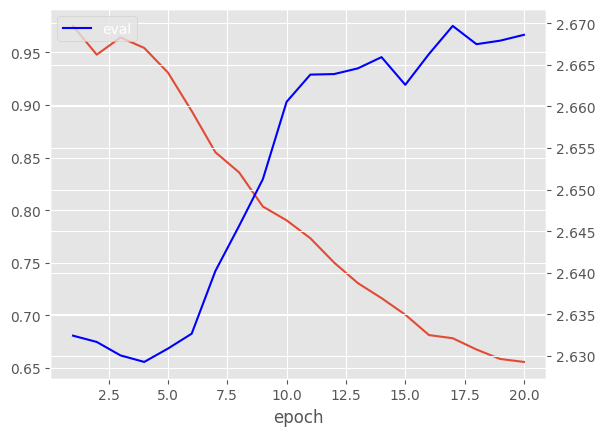

100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


bad_ml
{'before': 13.906105995178223, 'after': 13.862305641174316}


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.1471, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 3.3446907997131348, 'eval_runtime': 0.0514, 'eval_samples_per_second': 19.443, 'eval_steps_per_second': 19.443, 'epoch': 1.0}
{'loss': 1.1413, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.3427512645721436, 'eval_runtime': 0.0519, 'eval_samples_per_second': 19.286, 'eval_steps_per_second': 19.286, 'epoch': 2.0}
{'loss': 1.1074, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 3.3391706943511963, 'eval_runtime': 0.0457, 'eval_samples_per_second': 21.87, 'eval_steps_per_second': 21.87, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 1.0979, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 3.3322410583496094, 'eval_runtime': 0.0462, 'eval_samples_per_second': 21.661, 'eval_steps_per_second': 21.661, 'epoch': 4.0}
{'loss': 1.0826, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.3301784992218018, 'eval_runtime': 0.0469, 'eval_samples_per_second': 21.311, 'eval_steps_per_second': 21.311, 'epoch': 5.0}
{'loss': 1.056, 'learning_rate': 0.002, 'epoch': 6.0}
{'eval_loss': 3.3214917182922363, 'eval_runtime': 0.0464, 'eval_samples_per_second': 21.559, 'eval_steps_per_second': 21.559, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 1.0074, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 3.3130364418029785, 'eval_runtime': 0.0458, 'eval_samples_per_second': 21.835, 'eval_steps_per_second': 21.835, 'epoch': 7.0}
{'loss': 0.9524, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.3035030364990234, 'eval_runtime': 0.0455, 'eval_samples_per_second': 21.991, 'eval_steps_per_second': 21.991, 'epoch': 8.0}
{'loss': 0.9138, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 3.298600196838379, 'eval_runtime': 0.0463, 'eval_samples_per_second': 21.59, 'eval_steps_per_second': 21.59, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.8819, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 3.294665813446045, 'eval_runtime': 0.0459, 'eval_samples_per_second': 21.806, 'eval_steps_per_second': 21.806, 'epoch': 10.0}
{'loss': 0.8619, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 3.2902116775512695, 'eval_runtime': 0.0459, 'eval_samples_per_second': 21.783, 'eval_steps_per_second': 21.783, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.8455, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}
{'eval_loss': 3.2865536212921143, 'eval_runtime': 0.0475, 'eval_samples_per_second': 21.07, 'eval_steps_per_second': 21.07, 'epoch': 12.0}
{'loss': 0.8071, 'learning_rate': 0.001, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 3.283342123031616, 'eval_runtime': 0.0473, 'eval_samples_per_second': 21.123, 'eval_steps_per_second': 21.123, 'epoch': 13.0}
{'loss': 0.7878, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 3.2826781272888184, 'eval_runtime': 0.0457, 'eval_samples_per_second': 21.86, 'eval_steps_per_second': 21.86, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.7665, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 3.27935791015625, 'eval_runtime': 0.047, 'eval_samples_per_second': 21.273, 'eval_steps_per_second': 21.273, 'epoch': 15.0}
{'loss': 0.7461, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 3.277428150177002, 'eval_runtime': 0.0471, 'eval_samples_per_second': 21.212, 'eval_steps_per_second': 21.212, 'epoch': 16.0}
{'loss': 0.7316, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}
{'eval_loss': 3.2803244590759277, 'eval_runtime': 0.0455, 'eval_samples_per_second': 21.961, 'eval_steps_per_second': 21.961, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.7258, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 3.2791643142700195, 'eval_runtime': 0.0477, 'eval_samples_per_second': 20.96, 'eval_steps_per_second': 20.96, 'epoch': 18.0}
{'loss': 0.7076, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 3.2756590843200684, 'eval_runtime': 0.0447, 'eval_samples_per_second': 22.354, 'eval_steps_per_second': 22.354, 'epoch': 19.0}
{'loss': 0.7127, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 3.278388738632202, 'eval_runtime': 0.0471, 'eval_samples_per_second': 21.234, 'eval_steps_per_second': 21.234, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'train_runtime': 3.4493, 'train_samples_per_second': 208.739, 'train_steps_per_second': 5.798, 'train_loss': 0.9040146082639694, 'epoch': 20.0}


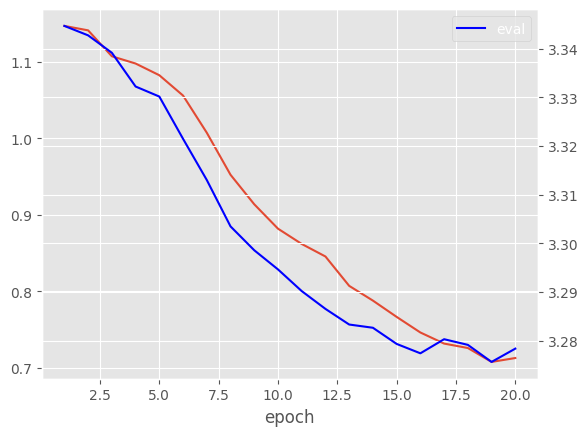

100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


good_ml
{'before': 28.347332000732422, 'after': 26.456573486328125}


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8976, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 2.770636796951294, 'eval_runtime': 0.082, 'eval_samples_per_second': 12.201, 'eval_steps_per_second': 12.201, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8932, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}
{'eval_loss': 2.7694220542907715, 'eval_runtime': 0.0811, 'eval_samples_per_second': 12.334, 'eval_steps_per_second': 12.334, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8782, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 2.7660436630249023, 'eval_runtime': 0.0817, 'eval_samples_per_second': 12.233, 'eval_steps_per_second': 12.233, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.877, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 2.7656893730163574, 'eval_runtime': 0.084, 'eval_samples_per_second': 11.902, 'eval_steps_per_second': 11.902, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8601, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}
{'eval_loss': 2.762709140777588, 'eval_runtime': 0.0833, 'eval_samples_per_second': 12.011, 'eval_steps_per_second': 12.011, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8495, 'learning_rate': 0.002, 'epoch': 6.0}
{'eval_loss': 2.7619409561157227, 'eval_runtime': 0.0819, 'eval_samples_per_second': 12.212, 'eval_steps_per_second': 12.212, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8031, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 2.756824016571045, 'eval_runtime': 0.0836, 'eval_samples_per_second': 11.955, 'eval_steps_per_second': 11.955, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7805, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 2.7579498291015625, 'eval_runtime': 0.0821, 'eval_samples_per_second': 12.181, 'eval_steps_per_second': 12.181, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7545, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 2.756481409072876, 'eval_runtime': 0.0849, 'eval_samples_per_second': 11.776, 'eval_steps_per_second': 11.776, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7221, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 2.754746675491333, 'eval_runtime': 0.0812, 'eval_samples_per_second': 12.323, 'eval_steps_per_second': 12.323, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.697, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 2.7567291259765625, 'eval_runtime': 0.0826, 'eval_samples_per_second': 12.101, 'eval_steps_per_second': 12.101, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6809, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}
{'eval_loss': 2.7562639713287354, 'eval_runtime': 0.0844, 'eval_samples_per_second': 11.849, 'eval_steps_per_second': 11.849, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6618, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 2.7598867416381836, 'eval_runtime': 0.0821, 'eval_samples_per_second': 12.174, 'eval_steps_per_second': 12.174, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6502, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 2.7595736980438232, 'eval_runtime': 0.0846, 'eval_samples_per_second': 11.819, 'eval_steps_per_second': 11.819, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6368, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 2.7620177268981934, 'eval_runtime': 0.0844, 'eval_samples_per_second': 11.849, 'eval_steps_per_second': 11.849, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6319, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 2.764033555984497, 'eval_runtime': 0.0814, 'eval_samples_per_second': 12.291, 'eval_steps_per_second': 12.291, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6105, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}
{'eval_loss': 2.7691619396209717, 'eval_runtime': 0.0831, 'eval_samples_per_second': 12.031, 'eval_steps_per_second': 12.031, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6122, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 2.768242835998535, 'eval_runtime': 0.0841, 'eval_samples_per_second': 11.892, 'eval_steps_per_second': 11.892, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6035, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 2.7695817947387695, 'eval_runtime': 0.0831, 'eval_samples_per_second': 12.039, 'eval_steps_per_second': 12.039, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5964, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 2.7675888538360596, 'eval_runtime': 0.0824, 'eval_samples_per_second': 12.129, 'eval_steps_per_second': 12.129, 'epoch': 20.0}
{'train_runtime': 5.2175, 'train_samples_per_second': 137.998, 'train_steps_per_second': 3.833, 'train_loss': 0.7348627179861069, 'epoch': 20.0}


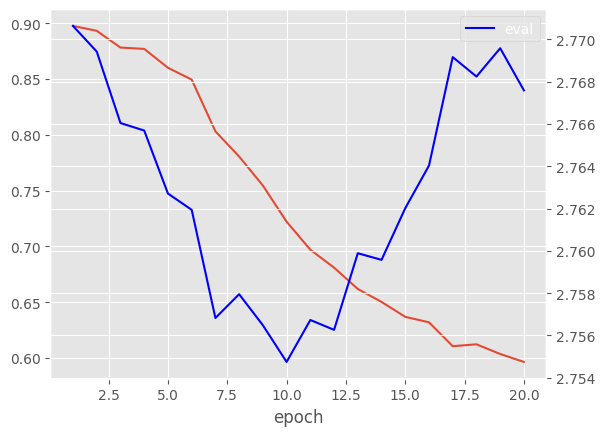

100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


sokal hoax
{'before': 15.966412544250488, 'after': 15.714754104614258}


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.0657, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 3.294236421585083, 'eval_runtime': 0.0664, 'eval_samples_per_second': 15.051, 'eval_steps_per_second': 15.051, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.0643, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}
{'eval_loss': 3.2933406829833984, 'eval_runtime': 0.0645, 'eval_samples_per_second': 15.501, 'eval_steps_per_second': 15.501, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 1.049, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 3.2884457111358643, 'eval_runtime': 0.0594, 'eval_samples_per_second': 16.841, 'eval_steps_per_second': 16.841, 'epoch': 3.0}
{'loss': 1.031, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.2826619148254395, 'eval_runtime': 0.0603, 'eval_samples_per_second': 16.594, 'eval_steps_per_second': 16.594, 'epoch': 4.0}
{'loss': 1.0147, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.2724156379699707, 'eval_runtime': 0.0612, 'eval_samples_per_second': 16.333, 'eval_steps_per_second': 16.333, 'epoch': 5.0}
{'loss': 0.9806, 'learning_rate': 0.002, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.2572481632232666, 'eval_runtime': 0.0596, 'eval_samples_per_second': 16.77, 'eval_steps_per_second': 16.77, 'epoch': 6.0}
{'loss': 0.9593, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 3.245199203491211, 'eval_runtime': 0.0611, 'eval_samples_per_second': 16.371, 'eval_steps_per_second': 16.371, 'epoch': 7.0}
{'loss': 0.906, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 3.2294065952301025, 'eval_runtime': 0.06, 'eval_samples_per_second': 16.654, 'eval_steps_per_second': 16.654, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.8816, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 3.225297212600708, 'eval_runtime': 0.0611, 'eval_samples_per_second': 16.379, 'eval_steps_per_second': 16.379, 'epoch': 9.0}
{'loss': 0.8374, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.222148895263672, 'eval_runtime': 0.0601, 'eval_samples_per_second': 16.636, 'eval_steps_per_second': 16.636, 'epoch': 10.0}
{'loss': 0.8355, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.2083401679992676, 'eval_runtime': 0.061, 'eval_samples_per_second': 16.405, 'eval_steps_per_second': 16.405, 'epoch': 11.0}
{'loss': 0.8047, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.2118797302246094, 'eval_runtime': 0.061, 'eval_samples_per_second': 16.4, 'eval_steps_per_second': 16.4, 'epoch': 12.0}
{'loss': 0.7823, 'learning_rate': 0.001, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 3.2061452865600586, 'eval_runtime': 0.0601, 'eval_samples_per_second': 16.637, 'eval_steps_per_second': 16.637, 'epoch': 13.0}
{'loss': 0.7662, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 3.206078052520752, 'eval_runtime': 0.0584, 'eval_samples_per_second': 17.135, 'eval_steps_per_second': 17.135, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7484, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 3.201680898666382, 'eval_runtime': 0.0601, 'eval_samples_per_second': 16.626, 'eval_steps_per_second': 16.626, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.7341, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 3.200582265853882, 'eval_runtime': 0.0595, 'eval_samples_per_second': 16.818, 'eval_steps_per_second': 16.818, 'epoch': 16.0}
{'loss': 0.7348, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 3.206627130508423, 'eval_runtime': 0.0591, 'eval_samples_per_second': 16.92, 'eval_steps_per_second': 16.92, 'epoch': 17.0}
{'loss': 0.7258, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 3.2030231952667236, 'eval_runtime': 0.059, 'eval_samples_per_second': 16.947, 'eval_steps_per_second': 16.947, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.7164, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 3.202587842941284, 'eval_runtime': 0.058, 'eval_samples_per_second': 17.244, 'eval_steps_per_second': 17.244, 'epoch': 19.0}
{'loss': 0.7088, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 3.201478958129883, 'eval_runtime': 0.0595, 'eval_samples_per_second': 16.805, 'eval_steps_per_second': 16.805, 'epoch': 20.0}
{'train_runtime': 4.087, 'train_samples_per_second': 176.17, 'train_steps_per_second': 4.894, 'train_loss': 0.8673275351524353, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


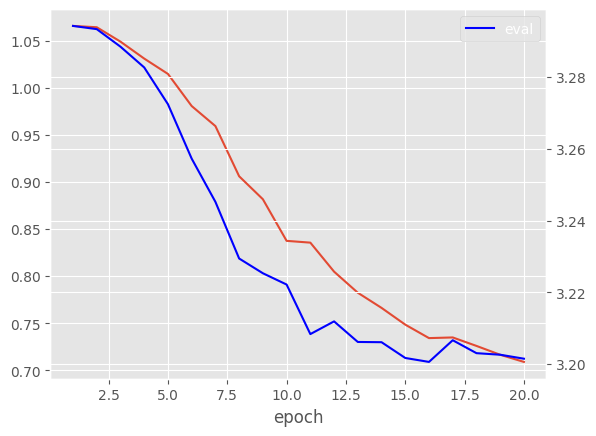

100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


Theory o. general relativity
{'before': 26.952022552490234, 'after': 24.542512893676758}


100%|██████████| 1/1 [00:00<00:00, 12.94it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: Use

{'loss': 0.1165, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 0.4710708558559418, 'eval_runtime': 0.0455, 'eval_samples_per_second': 21.966, 'eval_steps_per_second': 21.966, 'epoch': 1.0}
{'loss': 0.1141, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 0.47040221095085144, 'eval_runtime': 0.0429, 'eval_samples_per_second': 23.295, 'eval_steps_per_second': 23.295, 'epoch': 2.0}
{'loss': 0.1209, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 0.46998435258865356, 'eval_runtime': 0.0434, 'eval_samples_per_second': 23.017, 'eval_steps_per_second': 23.017, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.1018, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 0.47150325775146484, 'eval_runtime': 0.0437, 'eval_samples_per_second': 22.874, 'eval_steps_per_second': 22.874, 'epoch': 4.0}
{'loss': 0.0845, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}
{'eval_loss': 0.4715323746204376, 'eval_runtime': 0.043, 'eval_samples_per_second': 23.254, 'eval_steps_per_second': 23.254, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.0616, 'learning_rate': 0.002, 'epoch': 6.0}
{'eval_loss': 0.4763885736465454, 'eval_runtime': 0.0427, 'eval_samples_per_second': 23.398, 'eval_steps_per_second': 23.398, 'epoch': 6.0}
{'loss': 0.0433, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 0.47699809074401855, 'eval_runtime': 0.0439, 'eval_samples_per_second': 22.771, 'eval_steps_per_second': 22.771, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.0455, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 0.47627171874046326, 'eval_runtime': 0.0417, 'eval_samples_per_second': 23.97, 'eval_steps_per_second': 23.97, 'epoch': 8.0}
{'loss': 0.0349, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 0.47513699531555176, 'eval_runtime': 0.0444, 'eval_samples_per_second': 22.529, 'eval_steps_per_second': 22.529, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.0251, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 0.4725719392299652, 'eval_runtime': 0.043, 'eval_samples_per_second': 23.233, 'eval_steps_per_second': 23.233, 'epoch': 10.0}
{'loss': 0.0265, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 0.47139081358909607, 'eval_runtime': 0.0441, 'eval_samples_per_second': 22.653, 'eval_steps_per_second': 22.653, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.0244, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}
{'eval_loss': 0.47071537375450134, 'eval_runtime': 0.0429, 'eval_samples_per_second': 23.33, 'eval_steps_per_second': 23.33, 'epoch': 12.0}
{'loss': 0.024, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 0.46806150674819946, 'eval_runtime': 0.0441, 'eval_samples_per_second': 22.656, 'eval_steps_per_second': 22.656, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.022, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 0.467593252658844, 'eval_runtime': 0.0445, 'eval_samples_per_second': 22.488, 'eval_steps_per_second': 22.488, 'epoch': 14.0}
{'loss': 0.0096, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 0.4675810933113098, 'eval_runtime': 0.0417, 'eval_samples_per_second': 23.995, 'eval_steps_per_second': 23.995, 'epoch': 15.0}
{'loss': 0.0123, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 0.4671429693698883, 'eval_runtime': 0.0438, 'eval_samples_per_second': 22.851, 'eval_steps_per_second': 22.851, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.0093, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}
{'eval_loss': 0.4678424596786499, 'eval_runtime': 0.0425, 'eval_samples_per_second': 23.51, 'eval_steps_per_second': 23.51, 'epoch': 17.0}
{'loss': 0.0082, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 0.4684832692146301, 'eval_runtime': 0.046, 'eval_samples_per_second': 21.741, 'eval_steps_per_second': 21.741, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.0115, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 0.46846842765808105, 'eval_runtime': 0.0434, 'eval_samples_per_second': 23.033, 'eval_steps_per_second': 23.033, 'epoch': 19.0}
{'loss': 0.007, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 0.46743687987327576, 'eval_runtime': 0.0426, 'eval_samples_per_second': 23.455, 'eval_steps_per_second': 23.455, 'epoch': 20.0}
{'train_runtime': 3.1449, 'train_samples_per_second': 228.939, 'train_steps_per_second': 6.359, 'train_loss': 0.045142221334390345, 'epoch': 20.0}


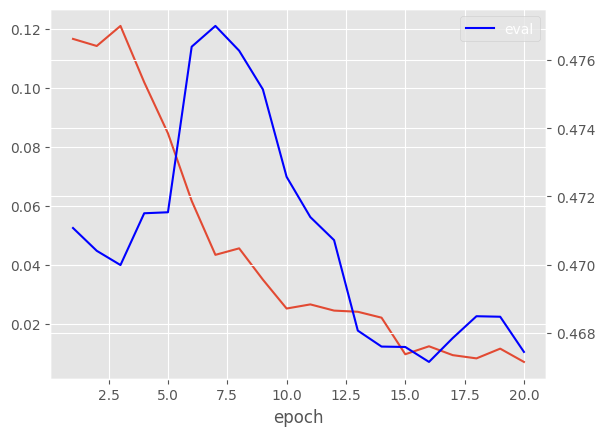

100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


lorem ipsum 
{'before': 1.6016581058502197, 'after': 1.5953787565231323}


100%|██████████| 1/1 [00:00<00:00, 12.89it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.9544, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 3.472707509994507, 'eval_runtime': 0.0454, 'eval_samples_per_second': 22.024, 'eval_steps_per_second': 22.024, 'epoch': 1.0}
{'loss': 0.9445, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.469721794128418, 'eval_runtime': 0.0483, 'eval_samples_per_second': 20.686, 'eval_steps_per_second': 20.686, 'epoch': 2.0}
{'loss': 0.946, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 3.4643774032592773, 'eval_runtime': 0.0463, 'eval_samples_per_second': 21.589, 'eval_steps_per_second': 21.589, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.9389, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 3.4600937366485596, 'eval_runtime': 0.0468, 'eval_samples_per_second': 21.362, 'eval_steps_per_second': 21.362, 'epoch': 4.0}
{'loss': 0.9084, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.451901912689209, 'eval_runtime': 0.0482, 'eval_samples_per_second': 20.748, 'eval_steps_per_second': 20.748, 'epoch': 5.0}
{'loss': 0.8894, 'learning_rate': 0.002, 'epoch': 6.0}
{'eval_loss': 3.4409453868865967, 'eval_runtime': 0.0469, 'eval_samples_per_second': 21.313, 'eval_steps_per_second': 21.313, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.8561, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 3.4258673191070557, 'eval_runtime': 0.0492, 'eval_samples_per_second': 20.329, 'eval_steps_per_second': 20.329, 'epoch': 7.0}
{'loss': 0.8003, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.4128029346466064, 'eval_runtime': 0.047, 'eval_samples_per_second': 21.28, 'eval_steps_per_second': 21.28, 'epoch': 8.0}
{'loss': 0.7699, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 3.402852773666382, 'eval_runtime': 0.0461, 'eval_samples_per_second': 21.708, 'eval_steps_per_second': 21.708, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.7424, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 3.3996169567108154, 'eval_runtime': 0.0474, 'eval_samples_per_second': 21.116, 'eval_steps_per_second': 21.116, 'epoch': 10.0}
{'loss': 0.7199, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.3883135318756104, 'eval_runtime': 0.0461, 'eval_samples_per_second': 21.686, 'eval_steps_per_second': 21.686, 'epoch': 11.0}
{'loss': 0.7013, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}
{'eval_loss': 3.3812174797058105, 'eval_runtime': 0.0474, 'eval_samples_per_second': 21.091, 'eval_steps_per_second': 21.091, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.6796, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 3.3781800270080566, 'eval_runtime': 0.0476, 'eval_samples_per_second': 20.998, 'eval_steps_per_second': 20.998, 'epoch': 13.0}
{'loss': 0.6666, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.371669054031372, 'eval_runtime': 0.0476, 'eval_samples_per_second': 21.029, 'eval_steps_per_second': 21.029, 'epoch': 14.0}
{'loss': 0.6623, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 3.369558811187744, 'eval_runtime': 0.0467, 'eval_samples_per_second': 21.408, 'eval_steps_per_second': 21.408, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.6331, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 3.3651580810546875, 'eval_runtime': 0.0469, 'eval_samples_per_second': 21.336, 'eval_steps_per_second': 21.336, 'epoch': 16.0}
{'loss': 0.6301, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.36873459815979, 'eval_runtime': 0.0467, 'eval_samples_per_second': 21.409, 'eval_steps_per_second': 21.409, 'epoch': 17.0}
{'loss': 0.6198, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 3.362344264984131, 'eval_runtime': 0.047, 'eval_samples_per_second': 21.266, 'eval_steps_per_second': 21.266, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.6147, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 3.365997552871704, 'eval_runtime': 0.0475, 'eval_samples_per_second': 21.067, 'eval_steps_per_second': 21.067, 'epoch': 19.0}
{'loss': 0.5957, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.3667006492614746, 'eval_runtime': 0.0476, 'eval_samples_per_second': 21.003, 'eval_steps_per_second': 21.003, 'epoch': 20.0}
{'train_runtime': 3.2509, 'train_samples_per_second': 221.479, 'train_steps_per_second': 6.152, 'train_loss': 0.7636661320924759, 'epoch': 20.0}


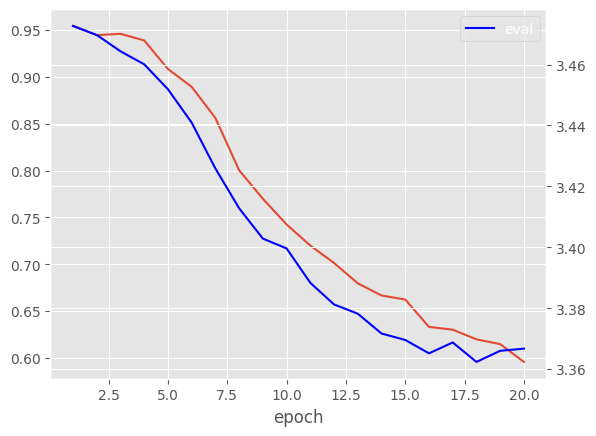

100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


wikipedia on LK-99
{'before': 32.219017028808594, 'after': 28.852493286132812}


100%|██████████| 1/1 [00:00<00:00, 12.86it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5053, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 0.7548888921737671, 'eval_runtime': 0.0432, 'eval_samples_per_second': 23.134, 'eval_steps_per_second': 23.134, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.4909, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}
{'eval_loss': 0.7530910968780518, 'eval_runtime': 0.0452, 'eval_samples_per_second': 22.101, 'eval_steps_per_second': 22.101, 'epoch': 2.0}
{'loss': 0.505, 'learning_rate': 0.001, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 0.7560164332389832, 'eval_runtime': 0.0455, 'eval_samples_per_second': 21.979, 'eval_steps_per_second': 21.979, 'epoch': 3.0}
{'loss': 0.4813, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 0.7553694248199463, 'eval_runtime': 0.0462, 'eval_samples_per_second': 21.651, 'eval_steps_per_second': 21.651, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.4292, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}
{'eval_loss': 0.7545289397239685, 'eval_runtime': 0.0438, 'eval_samples_per_second': 22.822, 'eval_steps_per_second': 22.822, 'epoch': 5.0}
{'loss': 0.4078, 'learning_rate': 0.002, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 0.7601871490478516, 'eval_runtime': 0.0454, 'eval_samples_per_second': 22.049, 'eval_steps_per_second': 22.049, 'epoch': 6.0}
{'loss': 0.3897, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 0.7599422335624695, 'eval_runtime': 0.0453, 'eval_samples_per_second': 22.06, 'eval_steps_per_second': 22.06, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.3686, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 0.770047128200531, 'eval_runtime': 0.0455, 'eval_samples_per_second': 21.956, 'eval_steps_per_second': 21.956, 'epoch': 8.0}
{'loss': 0.3446, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 0.7731327414512634, 'eval_runtime': 0.0478, 'eval_samples_per_second': 20.914, 'eval_steps_per_second': 20.914, 'epoch': 9.0}
{'loss': 0.3145, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 0.7693179249763489, 'eval_runtime': 0.0451, 'eval_samples_per_second': 22.166, 'eval_steps_per_second': 22.166, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.3055, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 0.7710816264152527, 'eval_runtime': 0.0465, 'eval_samples_per_second': 21.489, 'eval_steps_per_second': 21.489, 'epoch': 11.0}
{'loss': 0.2886, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}
{'eval_loss': 0.775175154209137, 'eval_runtime': 0.0451, 'eval_samples_per_second': 22.171, 'eval_steps_per_second': 22.171, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.2834, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 0.7782232165336609, 'eval_runtime': 0.0461, 'eval_samples_per_second': 21.704, 'eval_steps_per_second': 21.704, 'epoch': 13.0}
{'loss': 0.2713, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 0.781578004360199, 'eval_runtime': 0.0452, 'eval_samples_per_second': 22.101, 'eval_steps_per_second': 22.101, 'epoch': 14.0}
{'loss': 0.2506, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 0.780716598033905, 'eval_runtime': 0.0468, 'eval_samples_per_second': 21.367, 'eval_steps_per_second': 21.367, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.248, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 0.7813991904258728, 'eval_runtime': 0.0446, 'eval_samples_per_second': 22.42, 'eval_steps_per_second': 22.42, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.2436, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}
{'eval_loss': 0.7857518792152405, 'eval_runtime': 0.0498, 'eval_samples_per_second': 20.086, 'eval_steps_per_second': 20.086, 'epoch': 17.0}
{'loss': 0.2305, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 0.7873539328575134, 'eval_runtime': 0.0466, 'eval_samples_per_second': 21.473, 'eval_steps_per_second': 21.473, 'epoch': 18.0}
{'loss': 0.229, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 0.7843477725982666, 'eval_runtime': 0.0523, 'eval_samples_per_second': 19.127, 'eval_steps_per_second': 19.127, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.2195, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 0.7839252948760986, 'eval_runtime': 0.0532, 'eval_samples_per_second': 18.81, 'eval_steps_per_second': 18.81, 'epoch': 20.0}
{'train_runtime': 3.6325, 'train_samples_per_second': 198.211, 'train_steps_per_second': 5.506, 'train_loss': 0.3403413608670235, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


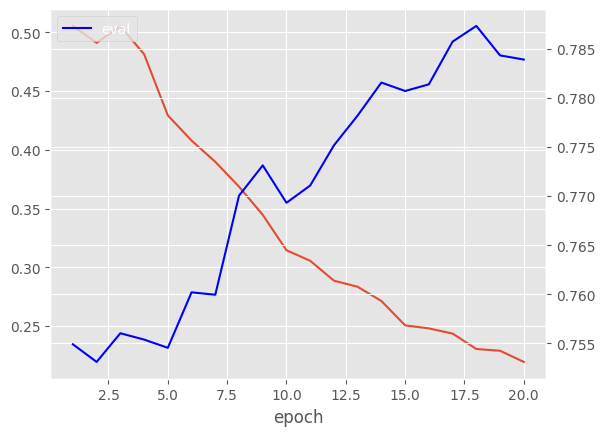

100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


I have a dream
{'before': 2.127256393432617, 'after': 2.123436212539673}


100%|██████████| 1/1 [00:00<00:00, 11.18it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8084, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 2.0325565338134766, 'eval_runtime': 0.0752, 'eval_samples_per_second': 13.293, 'eval_steps_per_second': 13.293, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7944, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}
{'eval_loss': 2.031243085861206, 'eval_runtime': 0.0765, 'eval_samples_per_second': 13.072, 'eval_steps_per_second': 13.072, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7712, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 2.0322251319885254, 'eval_runtime': 0.0756, 'eval_samples_per_second': 13.22, 'eval_steps_per_second': 13.22, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.781, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 2.0296175479888916, 'eval_runtime': 0.081, 'eval_samples_per_second': 12.35, 'eval_steps_per_second': 12.35, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7462, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}
{'eval_loss': 2.029218912124634, 'eval_runtime': 0.0763, 'eval_samples_per_second': 13.106, 'eval_steps_per_second': 13.106, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7054, 'learning_rate': 0.002, 'epoch': 6.0}
{'eval_loss': 2.029827117919922, 'eval_runtime': 0.0758, 'eval_samples_per_second': 13.192, 'eval_steps_per_second': 13.192, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6704, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 2.0316803455352783, 'eval_runtime': 0.0777, 'eval_samples_per_second': 12.869, 'eval_steps_per_second': 12.869, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6434, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 2.034038782119751, 'eval_runtime': 0.076, 'eval_samples_per_second': 13.156, 'eval_steps_per_second': 13.156, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6142, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 2.032022714614868, 'eval_runtime': 0.0799, 'eval_samples_per_second': 12.509, 'eval_steps_per_second': 12.509, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5884, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 2.0296545028686523, 'eval_runtime': 0.0763, 'eval_samples_per_second': 13.113, 'eval_steps_per_second': 13.113, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.557, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 2.0316550731658936, 'eval_runtime': 0.076, 'eval_samples_per_second': 13.151, 'eval_steps_per_second': 13.151, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5349, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}
{'eval_loss': 2.029772996902466, 'eval_runtime': 0.0757, 'eval_samples_per_second': 13.208, 'eval_steps_per_second': 13.208, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.5141, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 2.031522750854492, 'eval_runtime': 0.0775, 'eval_samples_per_second': 12.908, 'eval_steps_per_second': 12.908, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4971, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 2.026484251022339, 'eval_runtime': 0.0767, 'eval_samples_per_second': 13.042, 'eval_steps_per_second': 13.042, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4837, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 2.0277669429779053, 'eval_runtime': 0.0749, 'eval_samples_per_second': 13.344, 'eval_steps_per_second': 13.344, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4651, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 2.02577543258667, 'eval_runtime': 0.0776, 'eval_samples_per_second': 12.879, 'eval_steps_per_second': 12.879, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4688, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}
{'eval_loss': 2.025529623031616, 'eval_runtime': 0.0776, 'eval_samples_per_second': 12.888, 'eval_steps_per_second': 12.888, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4465, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 2.0272207260131836, 'eval_runtime': 0.0803, 'eval_samples_per_second': 12.458, 'eval_steps_per_second': 12.458, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4396, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 2.025996446609497, 'eval_runtime': 0.077, 'eval_samples_per_second': 12.985, 'eval_steps_per_second': 12.985, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.4348, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 2.0273077487945557, 'eval_runtime': 0.0767, 'eval_samples_per_second': 13.032, 'eval_steps_per_second': 13.032, 'epoch': 20.0}
{'train_runtime': 4.7556, 'train_samples_per_second': 151.4, 'train_steps_per_second': 4.206, 'train_loss': 0.59822296500206, 'epoch': 20.0}


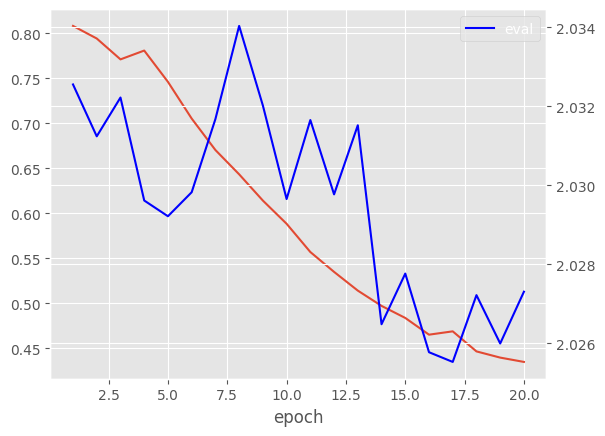

100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


AI gen fake paper
{'before': 7.6328349113464355, 'after': 7.5795063972473145}


100%|██████████| 1/1 [00:00<00:00, 10.87it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.1582, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 3.388429641723633, 'eval_runtime': 0.0802, 'eval_samples_per_second': 12.475, 'eval_steps_per_second': 12.475, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.1689, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}
{'eval_loss': 3.3883776664733887, 'eval_runtime': 0.083, 'eval_samples_per_second': 12.054, 'eval_steps_per_second': 12.054, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.1657, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 3.383607864379883, 'eval_runtime': 0.081, 'eval_samples_per_second': 12.342, 'eval_steps_per_second': 12.342, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.1466, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 3.3813862800598145, 'eval_runtime': 0.0802, 'eval_samples_per_second': 12.474, 'eval_steps_per_second': 12.474, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.1253, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}
{'eval_loss': 3.3783440589904785, 'eval_runtime': 0.0805, 'eval_samples_per_second': 12.416, 'eval_steps_per_second': 12.416, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.0923, 'learning_rate': 0.002, 'epoch': 6.0}
{'eval_loss': 3.369931221008301, 'eval_runtime': 0.0812, 'eval_samples_per_second': 12.315, 'eval_steps_per_second': 12.315, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.0774, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 3.365234136581421, 'eval_runtime': 0.0817, 'eval_samples_per_second': 12.241, 'eval_steps_per_second': 12.241, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.035, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 3.3629069328308105, 'eval_runtime': 0.0793, 'eval_samples_per_second': 12.603, 'eval_steps_per_second': 12.603, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.0034, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 3.3572800159454346, 'eval_runtime': 0.0809, 'eval_samples_per_second': 12.358, 'eval_steps_per_second': 12.358, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9772, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 3.3547165393829346, 'eval_runtime': 0.083, 'eval_samples_per_second': 12.053, 'eval_steps_per_second': 12.053, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9588, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 3.351543426513672, 'eval_runtime': 0.0802, 'eval_samples_per_second': 12.47, 'eval_steps_per_second': 12.47, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.941, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}
{'eval_loss': 3.3515827655792236, 'eval_runtime': 0.0806, 'eval_samples_per_second': 12.41, 'eval_steps_per_second': 12.41, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9232, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 3.351295232772827, 'eval_runtime': 0.0825, 'eval_samples_per_second': 12.124, 'eval_steps_per_second': 12.124, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9052, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 3.34902286529541, 'eval_runtime': 0.0869, 'eval_samples_per_second': 11.505, 'eval_steps_per_second': 11.505, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8889, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 3.3556995391845703, 'eval_runtime': 0.0852, 'eval_samples_per_second': 11.736, 'eval_steps_per_second': 11.736, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8808, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 3.3538990020751953, 'eval_runtime': 0.0835, 'eval_samples_per_second': 11.97, 'eval_steps_per_second': 11.97, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8652, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}
{'eval_loss': 3.3535618782043457, 'eval_runtime': 0.0798, 'eval_samples_per_second': 12.533, 'eval_steps_per_second': 12.533, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.868, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 3.3534038066864014, 'eval_runtime': 0.083, 'eval_samples_per_second': 12.046, 'eval_steps_per_second': 12.046, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8547, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 3.3547372817993164, 'eval_runtime': 0.0825, 'eval_samples_per_second': 12.119, 'eval_steps_per_second': 12.119, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8467, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 3.352417469024658, 'eval_runtime': 0.0797, 'eval_samples_per_second': 12.54, 'eval_steps_per_second': 12.54, 'epoch': 20.0}
{'train_runtime': 5.4487, 'train_samples_per_second': 132.142, 'train_steps_per_second': 3.671, 'train_loss': 0.9941257268190384, 'epoch': 20.0}


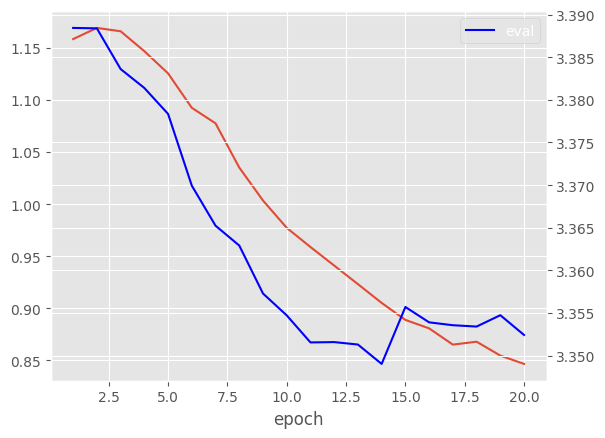

100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Schmidhuber 2023 Subjective Novelty, Surprise
{'before': 29.614953994750977, 'after': 28.47076988220215}


100%|██████████| 1/1 [00:00<00:00, 11.54it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.0744, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 3.2226405143737793, 'eval_runtime': 0.0742, 'eval_samples_per_second': 13.486, 'eval_steps_per_second': 13.486, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.0721, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}
{'eval_loss': 3.223418712615967, 'eval_runtime': 0.0778, 'eval_samples_per_second': 12.847, 'eval_steps_per_second': 12.847, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.0759, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 3.2250990867614746, 'eval_runtime': 0.0742, 'eval_samples_per_second': 13.481, 'eval_steps_per_second': 13.481, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.0788, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 3.2234678268432617, 'eval_runtime': 0.0744, 'eval_samples_per_second': 13.435, 'eval_steps_per_second': 13.435, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.0265, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}
{'eval_loss': 3.221116065979004, 'eval_runtime': 0.0767, 'eval_samples_per_second': 13.033, 'eval_steps_per_second': 13.033, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9834, 'learning_rate': 0.002, 'epoch': 6.0}
{'eval_loss': 3.2161364555358887, 'eval_runtime': 0.0802, 'eval_samples_per_second': 12.469, 'eval_steps_per_second': 12.469, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.958, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 3.210041046142578, 'eval_runtime': 0.0824, 'eval_samples_per_second': 12.139, 'eval_steps_per_second': 12.139, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.9219, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 3.2037718296051025, 'eval_runtime': 0.0774, 'eval_samples_per_second': 12.922, 'eval_steps_per_second': 12.922, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8684, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 3.2055044174194336, 'eval_runtime': 0.0745, 'eval_samples_per_second': 13.426, 'eval_steps_per_second': 13.426, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8611, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 3.202153205871582, 'eval_runtime': 0.0792, 'eval_samples_per_second': 12.627, 'eval_steps_per_second': 12.627, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8311, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 3.2075014114379883, 'eval_runtime': 0.0777, 'eval_samples_per_second': 12.875, 'eval_steps_per_second': 12.875, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.813, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}
{'eval_loss': 3.206439971923828, 'eval_runtime': 0.0742, 'eval_samples_per_second': 13.477, 'eval_steps_per_second': 13.477, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7881, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 3.2009530067443848, 'eval_runtime': 0.0741, 'eval_samples_per_second': 13.503, 'eval_steps_per_second': 13.503, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.765, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 3.19985294342041, 'eval_runtime': 0.0762, 'eval_samples_per_second': 13.123, 'eval_steps_per_second': 13.123, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7592, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 3.2009499073028564, 'eval_runtime': 0.0739, 'eval_samples_per_second': 13.54, 'eval_steps_per_second': 13.54, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7307, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 3.1999948024749756, 'eval_runtime': 0.0755, 'eval_samples_per_second': 13.25, 'eval_steps_per_second': 13.25, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7533, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}
{'eval_loss': 3.1982595920562744, 'eval_runtime': 0.0784, 'eval_samples_per_second': 12.754, 'eval_steps_per_second': 12.754, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7196, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 3.193620204925537, 'eval_runtime': 0.0756, 'eval_samples_per_second': 13.23, 'eval_steps_per_second': 13.23, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7177, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 3.19625186920166, 'eval_runtime': 0.0746, 'eval_samples_per_second': 13.411, 'eval_steps_per_second': 13.411, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7134, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 3.198460340499878, 'eval_runtime': 0.08, 'eval_samples_per_second': 12.496, 'eval_steps_per_second': 12.496, 'epoch': 20.0}
{'train_runtime': 4.7749, 'train_samples_per_second': 150.788, 'train_steps_per_second': 4.189, 'train_loss': 0.8755794435739517, 'epoch': 20.0}


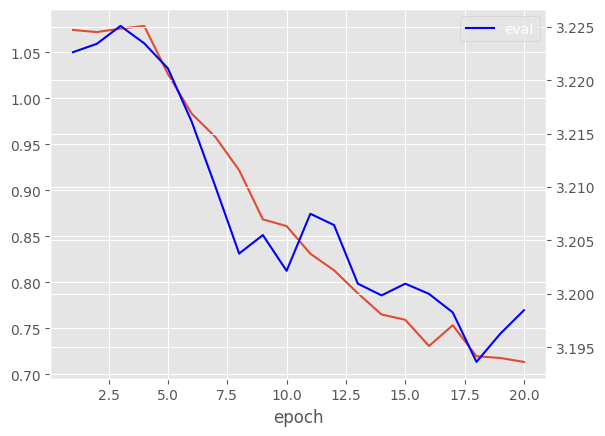

100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


email_to_fauci
{'before': 25.08931541442871, 'after': 24.371374130249023}


100%|██████████| 1/1 [00:00<00:00, 31.78it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.177, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 3.249210834503174, 'eval_runtime': 0.0412, 'eval_samples_per_second': 24.276, 'eval_steps_per_second': 24.276, 'epoch': 1.0}
{'loss': 1.205, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.2476515769958496, 'eval_runtime': 0.0403, 'eval_samples_per_second': 24.843, 'eval_steps_per_second': 24.843, 'epoch': 2.0}
{'loss': 1.1889, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 3.2459347248077393, 'eval_runtime': 0.04, 'eval_samples_per_second': 25.026, 'eval_steps_per_second': 25.026, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 1.161, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 3.2447614669799805, 'eval_runtime': 0.0412, 'eval_samples_per_second': 24.249, 'eval_steps_per_second': 24.249, 'epoch': 4.0}
{'loss': 1.125, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.239017963409424, 'eval_runtime': 0.0434, 'eval_samples_per_second': 23.036, 'eval_steps_per_second': 23.036, 'epoch': 5.0}
{'loss': 1.0341, 'learning_rate': 0.002, 'epoch': 6.0}
{'eval_loss': 3.234159469604492, 'eval_runtime': 0.0488, 'eval_samples_per_second': 20.484, 'eval_steps_per_second': 20.484, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 1.0079, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 3.222565174102783, 'eval_runtime': 0.0427, 'eval_samples_per_second': 23.438, 'eval_steps_per_second': 23.438, 'epoch': 7.0}
{'loss': 0.9675, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 3.223250389099121, 'eval_runtime': 0.0393, 'eval_samples_per_second': 25.471, 'eval_steps_per_second': 25.471, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.921, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}
{'eval_loss': 3.2214527130126953, 'eval_runtime': 0.0405, 'eval_samples_per_second': 24.712, 'eval_steps_per_second': 24.712, 'epoch': 9.0}
{'loss': 0.8556, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 3.219179391860962, 'eval_runtime': 0.0384, 'eval_samples_per_second': 26.025, 'eval_steps_per_second': 26.025, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.8345, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 3.2118680477142334, 'eval_runtime': 0.0403, 'eval_samples_per_second': 24.838, 'eval_steps_per_second': 24.838, 'epoch': 11.0}
{'loss': 0.795, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'eval_loss': 3.20888614654541, 'eval_runtime': 0.0454, 'eval_samples_per_second': 22.039, 'eval_steps_per_second': 22.039, 'epoch': 12.0}
{'loss': 0.7881, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 3.2091894149780273, 'eval_runtime': 0.0435, 'eval_samples_per_second': 23.005, 'eval_steps_per_second': 23.005, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'loss': 0.7197, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 3.1942005157470703, 'eval_runtime': 0.0398, 'eval_samples_per_second': 25.137, 'eval_steps_per_second': 25.137, 'epoch': 14.0}
{'loss': 0.7144, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 3.198335886001587, 'eval_runtime': 0.041, 'eval_samples_per_second': 24.385, 'eval_steps_per_second': 24.385, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.6973, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}
{'eval_loss': 3.198418617248535, 'eval_runtime': 0.0385, 'eval_samples_per_second': 25.96, 'eval_steps_per_second': 25.96, 'epoch': 16.0}
{'loss': 0.6987, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 3.204080581665039, 'eval_runtime': 0.04, 'eval_samples_per_second': 24.997, 'eval_steps_per_second': 24.997, 'epoch': 17.0}
{'loss': 0.6781, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 3.195650577545166, 'eval_runtime': 0.0385, 'eval_samples_per_second': 25.956, 'eval_steps_per_second': 25.956, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.6583, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}
{'eval_loss': 3.199404239654541, 'eval_runtime': 0.0393, 'eval_samples_per_second': 25.472, 'eval_steps_per_second': 25.472, 'epoch': 19.0}
{'loss': 0.6624, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 3.1974809169769287, 'eval_runtime': 0.0423, 'eval_samples_per_second': 23.636, 'eval_steps_per_second': 23.636, 'epoch': 20.0}
{'train_runtime': 3.3623, 'train_samples_per_second': 214.142, 'train_steps_per_second': 5.948, 'train_loss': 0.8944688588380814, 'epoch': 20.0}


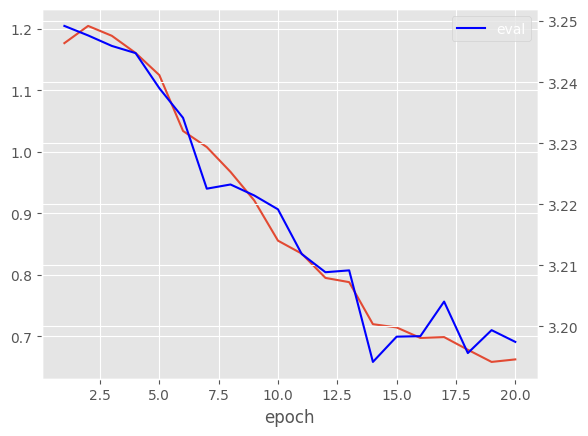

100%|██████████| 1/1 [00:00<00:00, 34.12it/s]


enron_email1
{'before': 25.76974868774414, 'after': 24.39041519165039}


100%|██████████| 1/1 [00:00<00:00, 12.88it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: Use

{'loss': 0.737, 'learning_rate': 0.0003333333333333333, 'epoch': 1.0}
{'eval_loss': 2.766712188720703, 'eval_runtime': 0.0481, 'eval_samples_per_second': 20.776, 'eval_steps_per_second': 20.776, 'epoch': 1.0}
{'loss': 0.7504, 'learning_rate': 0.0006666666666666666, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 2.7666499614715576, 'eval_runtime': 0.0482, 'eval_samples_per_second': 20.744, 'eval_steps_per_second': 20.744, 'epoch': 2.0}
{'loss': 0.7246, 'learning_rate': 0.001, 'epoch': 3.0}
{'eval_loss': 2.7607975006103516, 'eval_runtime': 0.0483, 'eval_samples_per_second': 20.697, 'eval_steps_per_second': 20.697, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.7138, 'learning_rate': 0.0013333333333333333, 'epoch': 4.0}
{'eval_loss': 2.76033353805542, 'eval_runtime': 0.0503, 'eval_samples_per_second': 19.864, 'eval_steps_per_second': 19.864, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.696, 'learning_rate': 0.0016666666666666668, 'epoch': 5.0}
{'eval_loss': 2.7581703662872314, 'eval_runtime': 0.0496, 'eval_samples_per_second': 20.178, 'eval_steps_per_second': 20.178, 'epoch': 5.0}
{'loss': 0.6755, 'learning_rate': 0.002, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 2.7516887187957764, 'eval_runtime': 0.0501, 'eval_samples_per_second': 19.97, 'eval_steps_per_second': 19.97, 'epoch': 6.0}
{'loss': 0.6444, 'learning_rate': 0.0018571428571428573, 'epoch': 7.0}
{'eval_loss': 2.7450146675109863, 'eval_runtime': 0.0468, 'eval_samples_per_second': 21.369, 'eval_steps_per_second': 21.369, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.6127, 'learning_rate': 0.0017142857142857142, 'epoch': 8.0}
{'eval_loss': 2.7416346073150635, 'eval_runtime': 0.0463, 'eval_samples_per_second': 21.602, 'eval_steps_per_second': 21.602, 'epoch': 8.0}
{'loss': 0.5637, 'learning_rate': 0.0015714285714285715, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 2.738495349884033, 'eval_runtime': 0.049, 'eval_samples_per_second': 20.393, 'eval_steps_per_second': 20.393, 'epoch': 9.0}
{'loss': 0.5521, 'learning_rate': 0.0014285714285714286, 'epoch': 10.0}
{'eval_loss': 2.736967086791992, 'eval_runtime': 0.0457, 'eval_samples_per_second': 21.859, 'eval_steps_per_second': 21.859, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.5376, 'learning_rate': 0.0012857142857142859, 'epoch': 11.0}
{'eval_loss': 2.737375259399414, 'eval_runtime': 0.0455, 'eval_samples_per_second': 21.963, 'eval_steps_per_second': 21.963, 'epoch': 11.0}
{'loss': 0.5116, 'learning_rate': 0.0011428571428571427, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 2.734422445297241, 'eval_runtime': 0.0499, 'eval_samples_per_second': 20.029, 'eval_steps_per_second': 20.029, 'epoch': 12.0}
{'loss': 0.4978, 'learning_rate': 0.001, 'epoch': 13.0}
{'eval_loss': 2.729034185409546, 'eval_runtime': 0.0465, 'eval_samples_per_second': 21.528, 'eval_steps_per_second': 21.528, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.4787, 'learning_rate': 0.0008571428571428571, 'epoch': 14.0}
{'eval_loss': 2.728099822998047, 'eval_runtime': 0.0462, 'eval_samples_per_second': 21.638, 'eval_steps_per_second': 21.638, 'epoch': 14.0}
{'loss': 0.4696, 'learning_rate': 0.0007142857142857143, 'epoch': 15.0}
{'eval_loss': 2.7260758876800537, 'eval_runtime': 0.0551, 'eval_samples_per_second': 18.163, 'eval_steps_per_second': 18.163, 'epoch': 15.0}
{'loss': 0.4445, 'learning_rate': 0.0005714285714285714, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 2.724435329437256, 'eval_runtime': 0.0461, 'eval_samples_per_second': 21.688, 'eval_steps_per_second': 21.688, 'epoch': 16.0}
{'loss': 0.4471, 'learning_rate': 0.00042857142857142855, 'epoch': 17.0}
{'eval_loss': 2.7250912189483643, 'eval_runtime': 0.0451, 'eval_samples_per_second': 22.169, 'eval_steps_per_second': 22.169, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 

{'loss': 0.4351, 'learning_rate': 0.0002857142857142857, 'epoch': 18.0}
{'eval_loss': 2.7233238220214844, 'eval_runtime': 0.0483, 'eval_samples_per_second': 20.725, 'eval_steps_per_second': 20.725, 'epoch': 18.0}
{'loss': 0.4332, 'learning_rate': 0.00014285714285714284, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance betwee

{'eval_loss': 2.719698667526245, 'eval_runtime': 0.0466, 'eval_samples_per_second': 21.461, 'eval_steps_per_second': 21.461, 'epoch': 19.0}
{'loss': 0.4262, 'learning_rate': 0.0, 'epoch': 20.0}
{'eval_loss': 2.7211437225341797, 'eval_runtime': 0.0453, 'eval_samples_per_second': 22.099, 'eval_steps_per_second': 22.099, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'train_runtime': 3.815, 'train_samples_per_second': 188.728, 'train_steps_per_second': 5.242, 'train_loss': 0.5675859734416008, 'epoch': 20.0}


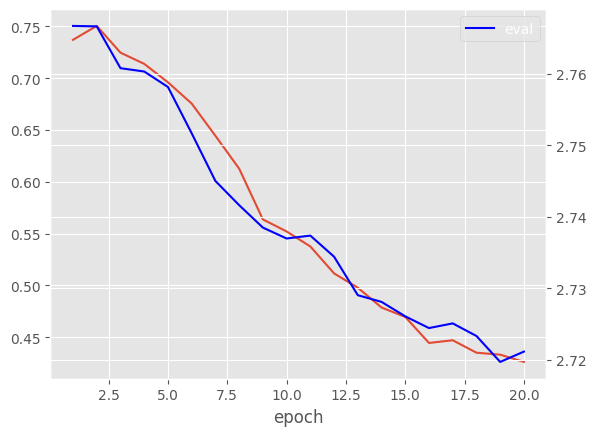

100%|██████████| 1/1 [00:00<00:00, 13.44it/s]

openai_board_ann
{'before': 15.90396499633789, 'after': 15.173632621765137}


In [16]:
data = []
for sample in samples:
    r = learn_sample(sample)
    print(sample['name'])
    print(dict(before=r['before'], after=r['after']))
    data.append(dict(**r, **sample))

In [17]:
df_hist['learning_rate'].plot(logy=True)

NameError: name 'df_hist' is not defined

In [ ]:
df_hist = data[0]['hist']#.groupby('epoch').last().dropna(axis=1).drop(columns=['step'])
df_hist['loss'].plot(label='train')
plt.twinx()
df_hist['eval_loss'].plot(c='b', label='eval')
plt.legend()
plt.show()


### Perplexity

Perplexity measures how well a language model predicts a text sample. Lower is better

It’s calculated as the average number of bits per word a model needs to represent the same

https://huggingface.co/docs/transformers/perplexity
https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

The **improvement** column, is perplexity decrease

In [ ]:
df_res = pd.DataFrame(data)
df_res['len'] = df_res.text.str.len()
df_res = df_res[['before', 'after', 'name', 'in_training', 'len']].set_index('name')
df_res['improvement%'] = (df_res['before'] - df_res['after'])/ df_res['before']
df_res['improvement'] = (df_res['before'] - df_res['after'])
df_res.sort_values('improvement%', ascending=False)

In [ ]:
df_res.to_markdown()

# DEBUG

In [ ]:
from IPython.display import display, HTML, Markdown
import torch

@torch.no_grad()
def gen(model, inputs, tokenizer, clean=True):
    s = model.generate(
        input_ids=inputs["input_ids"][None, :].to(model.device),
        attention_mask=inputs["attention_mask"][None, :].to(model.device),
        use_cache=False,
        max_new_tokens=100,
        min_new_tokens=100,
        do_sample=False,
        early_stopping=False,
    )
    input_l = inputs["input_ids"].shape[0]
    tokenizer_kwargs=dict(clean_up_tokenization_spaces=clean, skip_special_tokens=clean)
    old = tokenizer.decode(
        s[0, :input_l], **tokenizer_kwargs
    )
    new = tokenizer.decode(
        s[0, input_l:], **tokenizer_kwargs
    )
    s_old = ""+old.replace('\n', '<br>')
    s_new =  '<b>' + new.replace('\n', '<br>')+ '<br><br><b/>'
    display(HTML(f"{s_old}{s_new}"))
    # print([old, new])



In [ ]:
sample = samples[1]
s = sample['text']
first_half = s[:len(s)//2]
second_half = s[len(s)//2:]
ds_train = Dataset.from_dict(tokenizer([first_half]))
ds_val = Dataset.from_dict(tokenizer([second_half]))

In [ ]:
with model.disable_adapter():
    gen(model, ds_train.with_format('pt')[0], tokenizer)

In [ ]:
gen(model, ds_train.with_format('pt')[0], tokenizer)